In [1]:
include("./src/structs.jl")
include("./src/scalar_operators.jl")
include("./src/broadcast_operators.jl")
include("./src/graph.jl")
include("./src/forward.jl")
include("./src/backward.jl")
include("./src/data_loader.jl")
include("./src/nn_model.jl")

swish (generic function with 1 method)

In [6]:
rosenbrock(x, y) = (Constant(1.0) .- x .* x) .+ Constant(100.0) .* (y .- x .* x) .* (y .- x .* x)

import Random: shuffle, shuffle!, seed!
seed!(0)

input_neurons = 4
hidden_neurons = 8
output_neurons = 3
x = Variable(zeros(input_neurons), name="x")
y = Variable(zeros(output_neurons), name="y")
η = 0.001f0
epochs = 900

model = Network(
    Dense(input_neurons => hidden_neurons, 
          σ,
       #   bias = true,
          name="x̂"),
    Dense(hidden_neurons => output_neurons, 
          z -> let y = exp.(z); y ./ sum(y) end,
      #    bias = true,
          name="ŷ"),
)

function loss(x, y, model)
    ŷ = model(x)
    E = cross_entropy_loss(ŷ, y); E.name = "loss"
    return E
end

include("./data/iris.jl")
test_size  = 10
train_size = 140
data_size  = train_size + test_size
train_set  = shuffle(1:data_size)[1:train_size]
test_set   = setdiff(1:data_size, train_set)

10-element Vector{Int64}:
   7
  19
  30
  56
  99
 104
 124
 139
 147
 148

In [7]:
graph = topological_sort(loss(x, y, model))
for (i,n) in enumerate(graph)
    print(i, ". "); println(n)
end

1. Constant{Float32}(-1.0f0)
2. Variable([0.0, 0.0, 0.0], nothing, "y")
3. Variable(Float32[0.26013395 0.0016777263 -0.21997188 0.22988962 0.605725 0.08180131 0.550929 0.18372723; -0.50200176 -0.54571676 0.5320253 -0.13004501 0.41614506 -0.65478534 -0.13329604 0.083965555; 0.70820946 -0.71086276 0.3513509 0.40570804 -0.7268283 0.61009777 0.32201526 -0.6549786], nothing, "ŷ")
4. Variable(Float32[-0.6242165 -0.12525141 0.5265953 0.38508606; -0.06330246 -0.66517866 -0.24135628 0.1856245; 0.5811557 0.56866914 0.1625233 -0.22858815; 0.06737654 0.34922996 0.24324565 -0.57042027; 0.26178604 -0.38611746 0.25821882 0.44820222; 0.38658026 0.3490291 -0.56605566 0.28002855; -0.5477389 -0.29222813 -0.14231616 6.2377335f-6; 0.62308097 0.674113 -0.38164157 -0.04206247], nothing, "x̂")
5. Variable([0.0, 0.0, 0.0, 0.0], nothing, "x")
6. BroadcastedOperator{typeof(mul!)}((Variable(Float32[-0.6242165 -0.12525141 0.5265953 0.38508606; -0.06330246 -0.66517866 -0.24135628 0.1856245; 0.5811557 0.56866914 0.1

In [8]:
function test(set)
    L = 0.0
    for j = set
      x.output .= inputs[j,:]
      y.output .= targets[j,:]
      L += forward!(graph)
    end
    return L / length(set) 
end

function train!(batch, model, graph, lr=0.01f0)
    j = first(batch)
    x.output .= inputs[j,:]
    y.output .= targets[j,:]
    forward!(graph)
    backward!(graph)

    grads = gradient(model)

    for j in Iterators.drop(batch, 1)
        x.output .= inputs[j,:]
        y.output .= targets[j,:]

        forward!(graph)
        backward!(graph)
        
        accumulate_gradients!(grads, gradient(model))
    end

    update_params!(model, lr; grads, batch_len=length(batch))
    forward!(graph)
    return nothing
end

for i=1:epochs
    shuffle!(train_set)
    train!(train_set[1:10], model, graph, η)
    test(test_set)
end

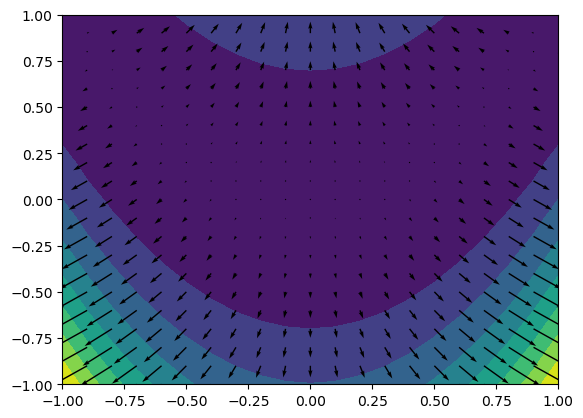

PyObject <matplotlib.quiver.Quiver object at 0x79d9d0b5f7d0>

In [16]:
x = Variable([0.], name="x")
y = Variable([0.], name="y")
graph = topological_sort(rosenbrock(x, y))


v  = -1:.1:+1
n  = length(v)
z  = zeros(n, n)
dz = zeros(n, n, 2)
for i=1:n, j=1:n
    x.output .= v[i]
    y.output .= v[j]
    z[i,j] = first(forward!(graph)); backward!(graph)
    dz[i,j,1] = first(x.∇)
    dz[i,j,2] = first(y.∇)
end

using PyPlot
xv = repeat(v, 1, n)
yv = repeat(v',n, 1)
contourf(xv, yv, z)
quiver(xv, yv, dz[:,:,1], dz[:,:,2])